<a href="https://colab.research.google.com/github/ahsank/runml/blob/main/Fintest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* https://www.coursera.org/learn/machine-learning-trading-finance/
* https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a
* https://medium.com/auquan/cointegration-and-stationarity-f4d14e1b3aef
* https://github.com/Auquan/Tutorials/blob/master/Integration,%20Cointegration,%20and%20Stationarity.ipynb
* https://github.com/Auquan/Tutorials.git
* https://haikulabs.com/pmdwkf26.htm
* https://www.haikulabs.com/publica8.htm
* https://github.com/razak2000/book_notes/blob/master/quantopian_lectures/notebooks/lecture_49_kalman_filters.ipynb
* https://github.com/colton-boxell/Machine-Learning-for-Trading/tree/main/Courses/Using%20Machine%20Learning%20in%20Trading%20and%20Finance/Lectures
* https://github.com/junbai94/quant_trading/blob/master/my%20algorithms/learning/Kalman_Filters.ipynb
* https://letianzj.github.io
* https://github.com/GoogleCloudPlatform/training-data-analyst
* https://www.yaoleixu.com/

## Experiments

* Use pct change instead of actual price

In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)


Stationary data A, Non sationary data B

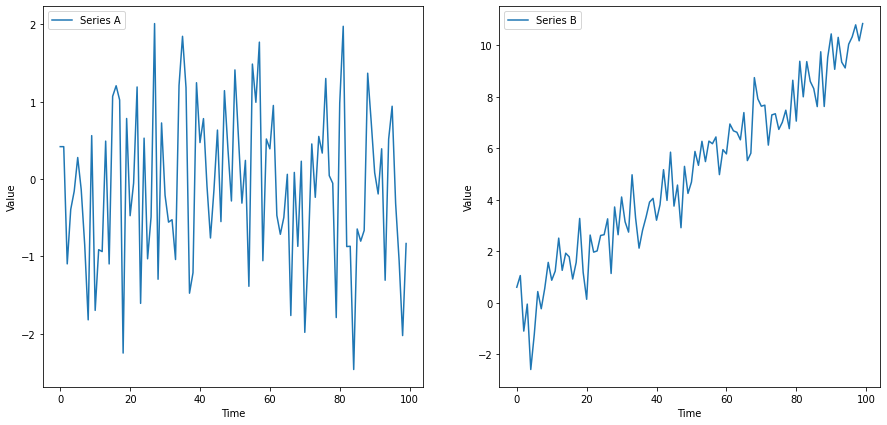

In [ ]:

# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T), dtype=float)
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)
fig = plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A'])


# Set the number of datapoints
T = 100

B = pd.Series(index=range(T), dtype=float)
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)
plt.subplot(1,2,2)
plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B'])
plt.show()

Checking for stationary

In [ ]:
def check_for_stationarity(X, cutoff=0.01):
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

check_for_stationarity(A);
check_for_stationarity(B);

p-value = 5.816556033136339e-17 The series A is likely stationary.
p-value = 0.8778960874687205 The series B is likely non-stationary.


In [ ]:
!pip install  auquan_toolbox

In [2]:
pip install -q yahoo_fin

     |████████████████████████████████| 81 kB 1.9 MB/s 
     |████████████████████████████████| 83 kB 318 kB/s 
     |████████████████████████████████| 50 kB 1.2 MB/s 
     |████████████████████████████████| 106 kB 40.4 MB/s 
     |████████████████████████████████| 127 kB 36.6 MB/s 


In [ ]:
# from backtester.dataSource.yahoo_data_source import YahooStockDataSource
# from datetime import datetime

# startDateStr = '2007/12/01'
# endDateStr = '2017/12/01'
# cachedFolderName = 'yahooData/'
# dataSetId = 'testPairsTrading'
# instrumentIds = ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
#                  'HPQ','JNPR','AMD','IBM']
# ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
#                             dataSetId=dataSetId,
#                             instrumentIds=instrumentIds,
#                             startDateStr=startDateStr,
#                             endDateStr=endDateStr,
#                             event='history')
# data = ds.getBookDataByFeature()['adjClose']

In [3]:
from yahoo_fin import stock_info as si
def get_data(ticker, start_date, end_date):
  df = si.get_data(ticker, start_date=start_date, end_date=end_date)
  # Remove duplicates
  df = df[~df.index.duplicated(keep='first')]
  return df
  

In [4]:
def get_data_tickers(tickers, attr, start_date, end_date):
  finaldf = None
  for ticker in tickers:
    try:
      df = get_data(ticker, start_date, end_date)
    except Exception as e:
      print(f'Issue with ticker {ticker}')
      raise e
    ds = df[attr]
    ds.name = ticker
    if finaldf is None:
      finaldf = ds.to_frame()
    else:
      finaldf[ticker] = ds
  
  # df = pd.concat(list, axis=1, keys=[s.name for s in list])
  return finaldf


In [ ]:
startDateStr = '2007/12/01'
endDateStr = '2017/12/01'
ds = get_data('AAPL', startDateStr, endDateStr)
X = ds['adjclose']
X

p-value = 0.9941055893965625 The series adjclose is likely non-stationary.
p-value = 0.0 The series adjclose Additive Returns is likely stationary.
p-value = 2.2663968095472915e-20 The series adjclose Multiplicative Returns is likely stationary.


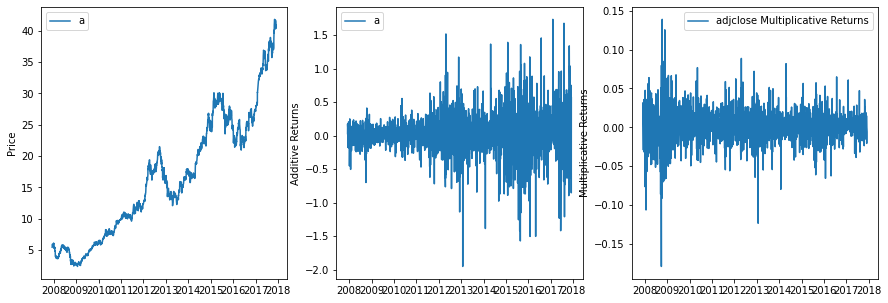

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(X.index, X.values)
plt.ylabel('Price')
plt.legend(X.name)
# plt.show()

check_for_stationarity(X)

X1 = X.diff()[1:]
X1.name = (str(X.name) + ' Additive Returns')
check_for_stationarity(X1)
plt.subplot(1, 3, 2)
plt.plot(X1.index, X1.values)
plt.ylabel('Additive Returns')
plt.legend(X1.name)
# plt.show()

X2 = X.pct_change()[1:]
X2.name = str(X.name) + ' Multiplicative Returns'
check_for_stationarity(X2)
plt.subplot(1,3,3)
plt.plot(X2.index, X2.values)
plt.ylabel('Multiplicative Returns')
plt.legend([X2.name])
plt.show()

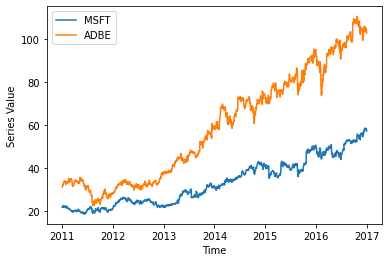

(-3.5589709806252032,
 0.027513677131827622,
 array([-3.90371244, -3.3401821 , -3.0472618 ]))

In [ ]:
startDateStr = '2011/01/01'
endDateStr = '2017/01/01'
X1 = get_data('MSFT', startDateStr, endDateStr)['adjclose']
X2 = get_data('ADBE', startDateStr, endDateStr)['adjclose']
X1.name = 'MSFT'
X2.name = 'ADBE'
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name])
plt.show()
from statsmodels.tsa.stattools import coint

coint(X1, X2)

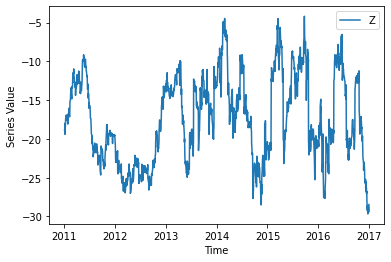

p-value = 0.004946122484862931 The series Z is likely stationary.


In [ ]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()

# Get rid of the constant column
X1 = X1['MSFT']

results.params

b = results.params['MSFT']
Z = X2 - b * X1
Z.name = 'Z'

plt.plot(Z.index, Z.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([Z.name])
plt.show()

check_for_stationarity(Z);


In [ ]:

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [ ]:
# from backtester.dataSource.yahoo_data_source import YahooStockDataSource
# from datetime import datetime

startDateStr = '2007/12/01'
endDateStr = '2017/12/01'
cachedFolderName = 'yahooData/'
# dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM']
#ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
#                            dataSetId=dataSetId,
#                            instrumentIds=instrumentIds,
#                            startDateStr=startDateStr,
#                            endDateStr=endDateStr,
#                            event='history')
# data = ds.getBookDataByFeature()['adjClose']


data = get_data_tickers(instrumentIds, 'adjclose',  startDateStr, endDateStr)


In [ ]:
data.head(3)

,SPY,AAPL,ADBE,EBAY,MSFT,QCOM,HPQ,JNPR,AMD,IBM
2007-12-03,109.930290,5.454156,42.689999,13.139489,24.235443,27.808697,16.221441,24.989517,9.66,63.350601
2007-12-04,108.947716,5.483125,43.320000,13.131513,24.125010,27.391138,16.308266,25.022430,9.25,63.829498
2007-12-05,110.771454,5.656637,43.900002,13.298993,25.140959,28.194298,16.613785,25.754753,8.91,64.745361


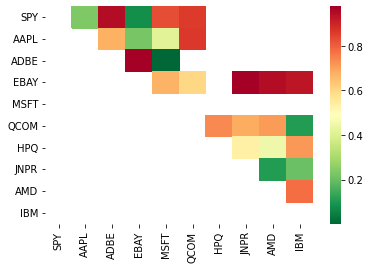

[('ADBE', 'MSFT')]


In [ ]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

0.001788798353675819


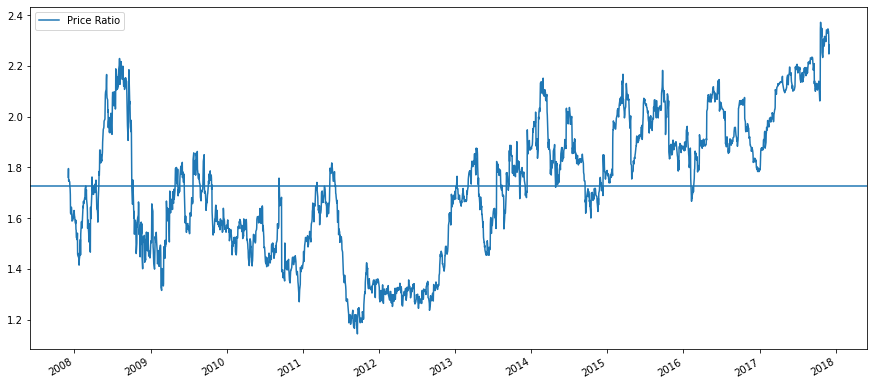

In [ ]:
S1 = data['ADBE']
S2 = data['MSFT']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

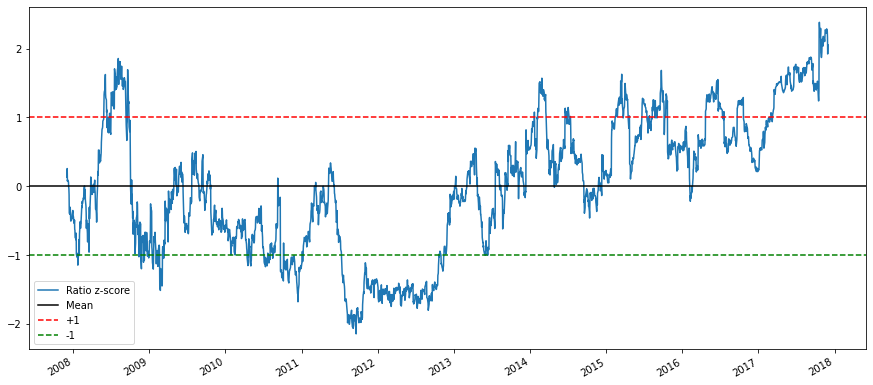

In [ ]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [ ]:
%pip install pykalman

In [ ]:
import pandas_datareader as pdr
from pykalman import KalmanFilter


In [ ]:
# Load pricing data for a security
start = '2017-11-01'
end = '2019-11-01'
# AAPL = pdr.DataReader('AAPL',data_source="yahoo", start=start, end=end)
# AAPL = AAPL['Adj Close']
# SPY = pdr.DataReader('LMT',data_source="yahoo", start=start, end=end)
# SPY = SPY['Adj Close']
# x = AAPL
# y = SPY

instrumentIds = ['AAPL','SPY']

data = get_data_tickers(instrumentIds, 'adjclose',  start, end)

x = data['AAPL']
y = data['SPY']


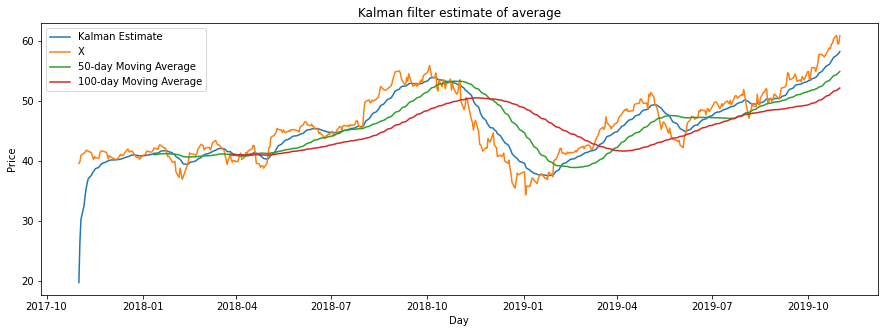

In [ ]:
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices=[1],
				observation_matrices=[1],
				initial_state_mean = 0,
				initial_state_covariance=1,
				observation_covariance=1,
				transition_covariance=.01)

# User the observed values of the price to get a rolling mean
state_means,_ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)
# Compute the rolling mean with various lookback windows
mean50 = x.rolling(window=50).mean()
mean100 = x.rolling(window=100).mean()

# Plot original data and estimated mean
plt.figure(figsize=(15,5))
plt.plot(state_means)
plt.plot(x)
plt.plot(mean50)
plt.plot(mean100)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '50-day Moving Average', '100-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

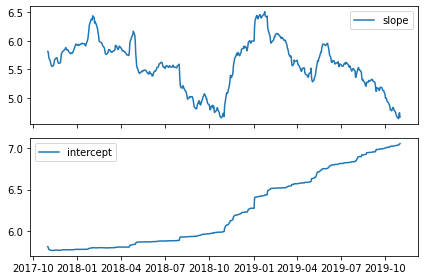

In [ ]:
delta = 1e-3
trans_conv = delta/(1-delta)*np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x],np.ones(len(x))]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
				# y is 1-dimensional, (alpha, beta) is 2-dimensional
				initial_state_mean=[0,0],
				initial_state_covariance=np.ones((2,2)),
				transition_matrices=np.eye(2),
				observation_matrices=obs_mat,
				observation_covariance=2,
				transition_covariance=trans_conv)

# Use the observations y to get running estimates and errors for the state parameters
state_means,state_covs = kf.filter(y.values)
_,axarr = plt.subplots(2,sharex=True)
axarr[0].plot(x.index,state_means[:,0],label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout()
plt.show()

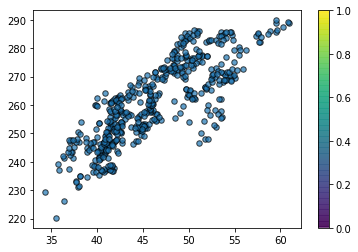

In [ ]:
# Plot data point using colormap
sc = plt.scatter(x,y,s=30,edgecolor='k',alpha=0.7)
cb = plt.colorbar(sc)

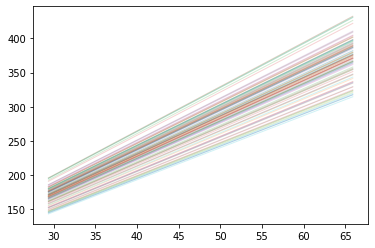

In [ ]:
# Plot every 5th line
step = 5
xi = np.linspace(x.min()-5,x.max()+5,2)
colors_l=np.linspace(0.1,1,len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
	plt.plot(xi,beta[0]*xi + beta[1], alpha=.2,lw=1)


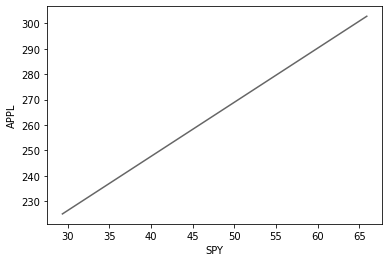

In [ ]:
# Plot the OLS regression line
plt.plot(xi,np.poly1d(np.polyfit(x,y,1))(xi), '0.4')

# Adjust axes for visibility
#plt.axis([225,300,125,250])

# Label axes
plt.xlabel('SPY')
plt.ylabel('APPL')
plt.show()

In [ ]:
# Get returns from pricing data
x_r=x.pct_change()[1:]
y_r=y.pct_change()[1:]

# Run Kalman filter on returns data
delta_r = 1e-2
trans_cov_r = delta_r/(1 - delta_r)*np.eye(2) 
# How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[x_r],[np.ones(len(x_r))]]).T, axis=1)
kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
				# y_r is 1-dimensional, (alpha, beta) is 2-dimensional
				initial_state_mean=[0,0],
				initial_state_covariance=np.ones((2,2)),
				transition_matrices=np.eye(2),
				observation_matrices=obs_mat_r,
				observation_covariance=.01,
				transition_covariance=trans_cov_r)
state_means,state_covs = kf_r.filter(y_r.values)

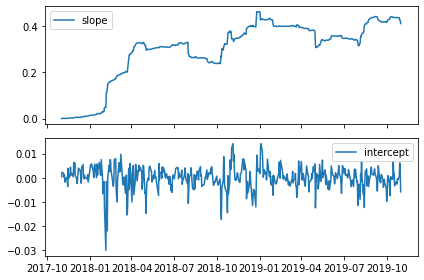

In [ ]:
_,axarr = plt.subplots(2,sharex=True)
axarr[0].plot(x_r.index,state_means[:,0],label='slope')
axarr[0].legend()
axarr[1].plot(x_r.index,state_means[:,1],label='intercept')
axarr[1].legend()
plt.tight_layout()
plt.show()

In [93]:
start = '2015-11-01'
end = '2019-11-01'
xlk_tickers = ['AAPL', 'MSFT', 'NVDA', 'V', 'MA', 'AVGO', 'CSCO', 'ACN', 'ADBE', 'TXN', 'CRM', 'QCOM', 'AMD', 'INTC',
               'INTU', 'ORCL', 'IBM', 'PYPL', 'ADP', 'NOW', 'AMAT', "ADI", 'MU', 'LRCX', 'FISV']
# xlk_tickers = ['AAPL', 'MSFT', 'NVDA', 'ADBE', 'CRM', 'QCOM', 'AMD', 'INTC',
#                'INTU', 'ORCL', 'IBM', 'PYPL', 'ADP', 'NOW', 'AMAT', 'MU', 'LRCX']           
xlk_prices = get_data_tickers(xlk_tickers, 'adjclose',  start, end)
market_price = get_data('XLK', start, end)['adjclose']

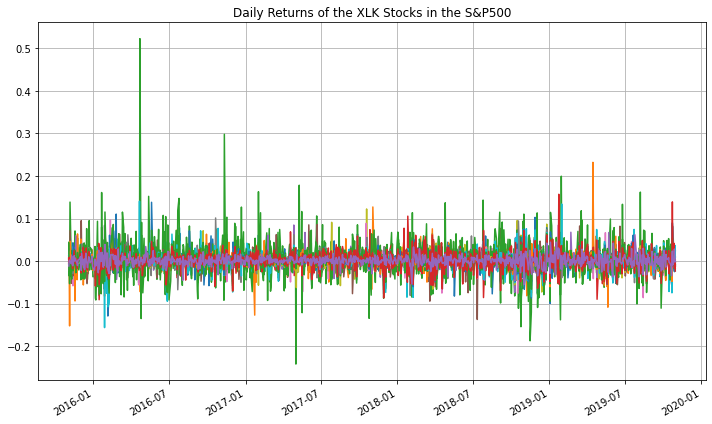

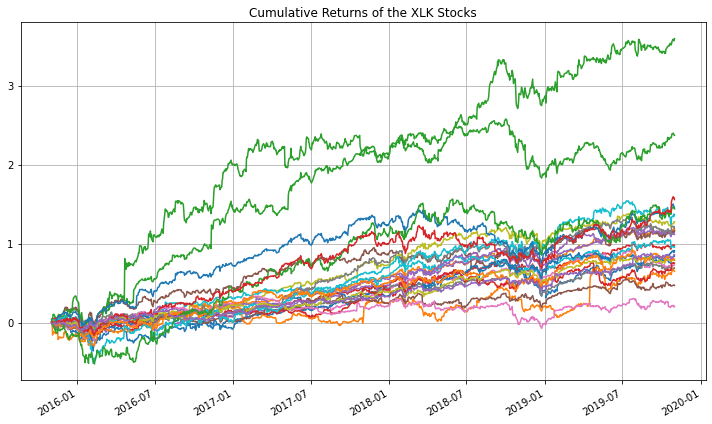

In [94]:
# rs = xlk_prices.apply(np.log).diff(1)[1:]
rs = xlk_prices.pct_change()[1:]
# rs = rs.clip(lower=-0.25, upper=0.25)
market_rs = market_price.pct_change()[1:]
rs.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the XLK Stocks in the S&P500')
plt.tight_layout()
# rs.cumsum().apply(np.exp)).plot(legend=0, figsize=(10,6), grid=True, title='Cumulative Returns of the XLK Stocks')
rs.cumsum().plot(legend=0, figsize=(10,6), grid=True, title='Cumulative Returns of the XLK Stocks')

plt.tight_layout()

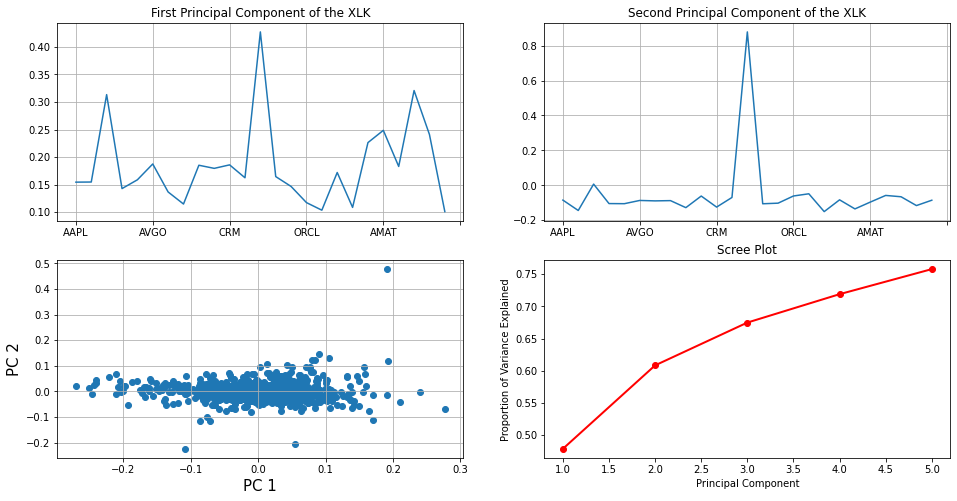

In [95]:
from sklearn.decomposition import PCA
pca = PCA(5)
pca_data = pca.fit_transform(rs.fillna(0))
# pca_df = pd.DataFrame(data = pca, columns = ['PC 1', 'PC 2'])

fig = plt.figure(figsize = (16,8))
pc1 = pd.Series(index=rs.columns, data=pca.components_[0])
pc2 = pd.Series(index=rs.columns, data=pca.components_[1])
fig.add_subplot(2,2,1) 
pc1.plot(grid=True, title='First Principal Component of the XLK')
fig.add_subplot(2,2,2) 
pc2.plot(grid=True, title='Second Principal Component of the XLK')


ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)

ax.scatter(pca_data[:, 0]
               , pca_data[:, 1])

ax.grid()

PC_values = np.arange(pca.n_components_) + 1
ax1 = fig.add_subplot(2,2,4) 
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.plot(PC_values, pca.explained_variance_ratio_.cumsum(), 'ro-', linewidth=2)
#plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


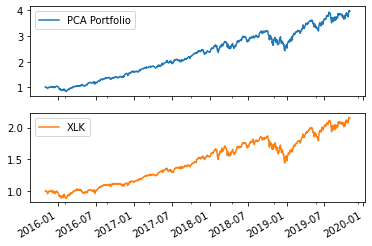

In [96]:
weights = abs(pc1)/sum(abs(pc1)) # l1norm = 1
myrs = (weights*rs).sum(1)
rs_df = pd.concat([myrs, market_rs], 1)
rs_df.columns = ["PCA Portfolio", "XLK"]
crs_df = rs_df.cumsum().apply(np.exp)
crs_df.plot(subplots=True);

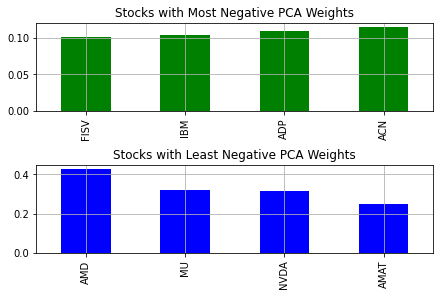

In [97]:
fig, ax = plt.subplots(2,1 , constrained_layout=True)
pc1.nsmallest(4).plot.bar( ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(4).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')


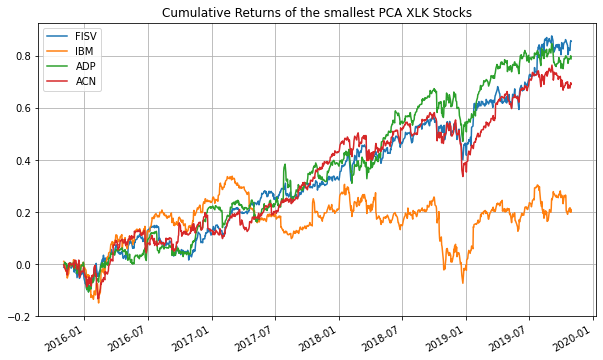

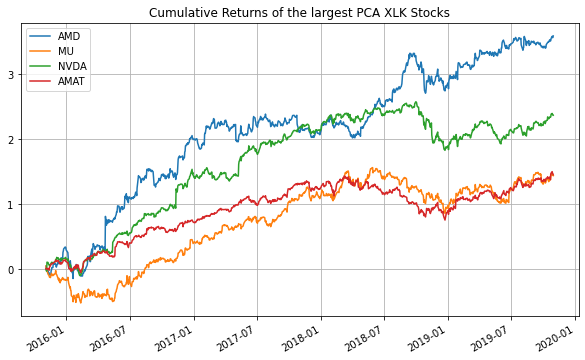

In [98]:
rssm = rs[pc1.nsmallest(4).index]
rssm.cumsum().plot(figsize=(10,6), grid=True, title='Cumulative Returns of the smallest PCA XLK Stocks')
rslg = rs[pc1.nlargest(4).index]
rslg.cumsum().plot(figsize=(10,6), grid=True, title='Cumulative Returns of the largest PCA XLK Stocks')


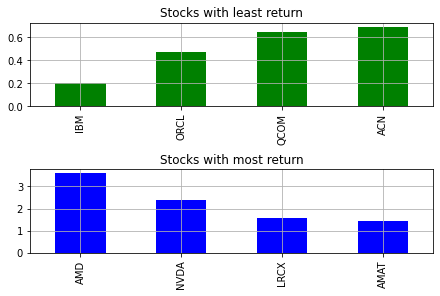

In [99]:
returns = rs.cumsum()[-1:].squeeze()
fig, ax = plt.subplots(2,1 , constrained_layout=True)
returns.nsmallest(4).plot.bar( ax=ax[0], color='green', grid=True, title='Stocks with least return')
returns.nlargest(4).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with most return')


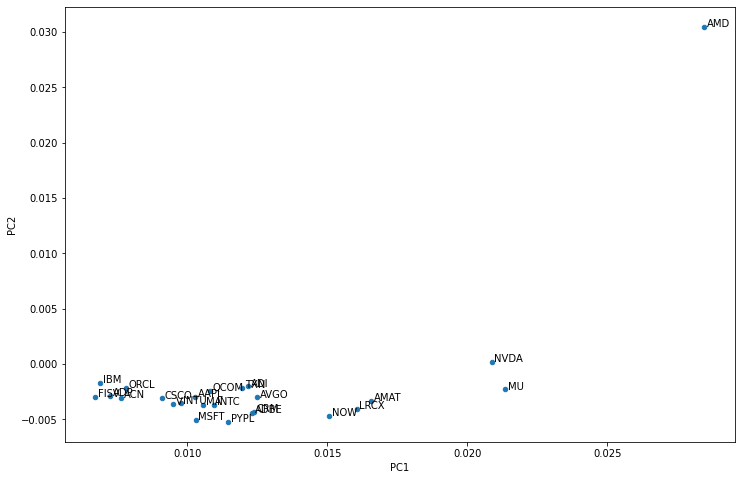

In [100]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loadings_matrix = pd.DataFrame(loadings[:, :2], columns=['PC1', 'PC2'], index=xlk_tickers)
loadings_matrix.reset_index(inplace=True)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.0001, point['y']+0.00001, str(point['val']))

ax = loadings_matrix.plot.scatter('PC1', 'PC2', figsize=(12,8))
label_point(loadings_matrix['PC1'], loadings_matrix['PC2'], loadings_matrix['index'], ax)
# sc = plt.text(loadings_matrix.loc[:, 'PC1'], loadings_matrix.loc[:, 'PC2'])
# cb = plt.colorbar(sc)